## Conducting market basket analysis to identify associations between grocery items using Apriori Algorithm

In [1]:
import pandas as pd
import seaborn as sbn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from apyori import apriori
import networkx as nx
import ipywidgets as widgets

In [2]:
grocery_df = pd.read_csv("./Groceries_dataset.csv")

In [3]:
grocery_df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


* Creates a new column with just the month and year of the purchase

In [4]:
x = grocery_df['Date'].str.split("-")
grocery_df['month_year'] = x.str[1]+"-"+x.str[2]
grocery_df.head()

,Member_number,Date,itemDescription,month_year
0,1808,21-07-2015,tropical fruit,07-2015
1,2552,05-01-2015,whole milk,01-2015
2,2300,19-09-2015,pip fruit,09-2015
3,1187,12-12-2015,other vegetables,12-2015
4,3037,01-02-2015,whole milk,02-2015


- Plots a graph to show the monthly consumption of various items; helps to determine the month with maximum consumption

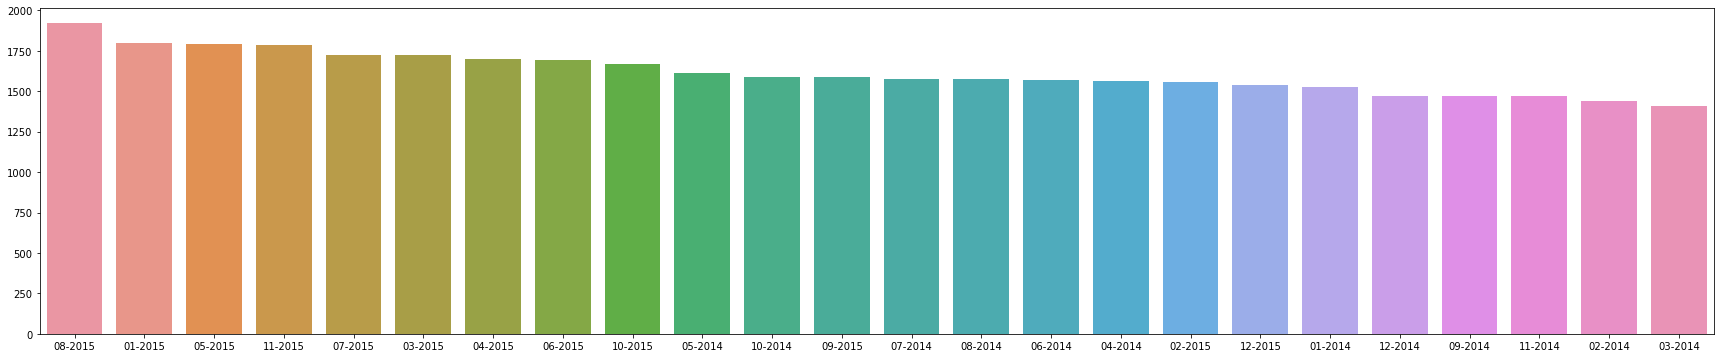

In [5]:
plt.figure(figsize=(30, 6))
purchase_date = grocery_df['month_year'].value_counts(ascending=False)
sbn.barplot(purchase_date.index, purchase_date.values)

In [6]:
products = grocery_df["itemDescription"].unique()
product_dummies = pd.get_dummies(grocery_df["itemDescription"])
grocery_df.drop('itemDescription', axis=1, inplace=True)
grocery_df = grocery_df.join(product_dummies)

- Creating a data frame to determine the associated items

In [7]:
member_shopping_df = grocery_df.groupby(["Member_number","Date"])[products[:]].sum()
def associate_product(row):
    for product in products:
        if row[product]!=0:
            row[product] = product
    return row
member_shopping_df = member_shopping_df.apply(associate_product, axis=1)
member_shopping_df.head()

tropical fruit  whole milk pip fruit  \
Member_number Date                                              
1000          15-03-2015              0  whole milk         0   
              24-06-2014              0  whole milk         0   
              24-07-2015              0           0         0   
              25-11-2015              0           0         0   
              27-05-2015              0           0         0   

                         other vegetables rolls/buns pot plants citrus fruit  \
Member_number Date                                                             
1000          15-03-2015                0          0          0            0   
              24-06-2014                0          0          0            0   
              24-07-2015                0          0          0            0   
              25-11-2015                0          0          0            0   
              27-05-2015                0          0          0            0   

                         beef frankfurter chicken  ... flower (seeds) rice  \
Member_number Date                                 ...                       
1000          15-03-2015    0           0       0  ...              0    0   
              24-06-2014    0           0       0  ...              0    0   
              24-07-2015    0           0       0  ...              0    0   
              25-11-2015    0           0       0  ...              0    0   
              27-05-2015    0           0       0  ...              0    0   

                         tea salad dressing specialty vegetables  \
Member_number Date                                                 
1000          15-03-2015   0              0                    0   
              24-06-2014   0              0                    0   
              24-07-2015   0              0                    0   
              25-11-2015   0              0                    0   
              27-05-2015   0              0                    0   

                         pudding powder ready soups make up remover  \
Member_number Date                                                    
1000          15-03-2015              0           0               0   
              24-06-2014              0           0               0   
              24-07-2015              0           0               0   
              25-11-2015              0           0               0   
              27-05-2015              0           0               0   

                         toilet cleaner preservation products  
Member_number Date                                             
1000          15-03-2015              0                     0  
              24-06-2014              0                     0  
              24-07-2015              0                     0  
              25-11-2015              0                     0  
              27-05-2015              0                     0  

[5 rows x 167 columns]

# Finding correlated items using Apriori algorithm
- Apriori Algorithm determines frequent itemsets in the database
   > Support = (frequency of the item)/(total no. of collection)
- Only items with support > 0.0003 are considered in this exercise

In [8]:
associated_items = []
for row in member_shopping_df.values:
    new_row = []
    for item in row:
        if(item!=0):
            new_row.append(item)
    associated_items.append(new_row)

support_map = {}

for record in list(apriori(associated_items, min_support=0.0003)):
    if(len(record.items)>1):
        items = set(record.items)
        support = record.support
        if support not in support_map:
            support_map[support] = []
        support_map[support].append(items)

In [9]:
values = support_map.keys()
rounded_vals = []
disp_map = {}
for val in values:
    rounded_vals.append(round(val, 7))
    disp_map[round(val, 7)] = support_map[val]

class ProductRelations:
    def __init__(self, support_val):
        self.support_value = support_val
        self.related_products = []
    
    def add_related_product(self, product):
        self.related_products.append(product)
    
    def __str__(self):
        x="{} - {}".format(self.support_value, self.related_products)
        return x



def get_product_relation_map():
    product_relation_map = {}
    for support_val, support_item_list in disp_map.items():
        for item_set in support_item_list:
            for item in item_set:
                if item not in product_relation_map:
                    product_relation_map[item] = []
                product_relations = ProductRelations(support_val)
                for related_item in item_set:
                    product_relations.add_related_product(related_item)
                product_relation_map[item].append(product_relations)
    return product_relation_map


class DisplayModels:
    
    def __init__(self):
        self.network_canvas = None
        self.items_dropdown = None
        self.controls_box = None
        self.main_panel = None
        self.count_slider = None

display_model = DisplayModels()

prod_rel_map = get_product_relation_map()
display_model.items_dropdown = widgets.Dropdown(options = prod_rel_map.keys())
display_model.controls_box = widgets.HBox([display_model.items_dropdown])
display_model.main_panel = widgets.VBox([display_model.controls_box])

def draw_graph(products, support):
    graph = nx.Graph()
    graph.add_nodes_from(products)
    edge_list = set()
    for item_x in products:
        for item_y in products:
            if(item_x!=item_y):
                if((item_y, item_x)) not in edge_list:
                    edge_list.add((item_x, item_y))
    graph.add_edges_from(edge_list)
    out = widgets.Output()
    with out:
        pos = nx.shell_layout(graph)
        display_model.network_canvas = plt.figure(figsize=(10,10))
        nx.draw(graph, pos=pos, node_size=400, with_labels=True, font_size=17)
        x_vals, y_vals = zip(*pos.values())
        x_min = min(x_vals)
        x_max = max(x_vals)
        y_min = min(y_vals)
        y_max = max(y_vals)
        plt.xlim(x_min-2, x_max+2)
        plt.ylim(y_min-1, y_max+1)
        plt.show()
    return out
    
    
def count_slider_change(args):
    if(args['name']=='value'):
        relation_list = prod_rel_map[display_model.items_dropdown.value]
        new_counter_index = int(args['new']) - 1
        out = draw_graph(relation_list[new_counter_index].related_products, 
                         relation_list[new_counter_index].support_value)
        display_model.main_panel.children = (display_model.controls_box, out)



def item_dropdown_change(args):
    global network_canvas
    if(args['name']=='value'):
        selected_item = args['new']
        relation_list = prod_rel_map[selected_item]
        display_model.count_slider = widgets.SelectionSlider(options=list(range(1,len(relation_list))))
        display_model.count_slider.observe(count_slider_change)
        display_model.controls_box.children = (display_model.items_dropdown,display_model.count_slider)
        out = draw_graph(relation_list[display_model.count_slider.value-1].related_products, 
                         relation_list[display_model.count_slider.value-1].support_value)
        display_model.main_panel.children = (display_model.controls_box, out)
        



display_model.items_dropdown.observe(item_dropdown_change)
display(display_model.main_panel)